# Getting Started with Azure Machine Learning

Azure Machine Learning (*Azure ML*) is a cloud-based service for creating and managing machine learning solutions. It's designed to help data scientists leverage their existing data processing and model development skills and frameworks, and help them scale their workloads to the cloud. The Azure ML SDK for Python provides classes you can use to work with Azure ML in your Azure subscription.

## Before You Start

1. Complete the steps in [Lab 1 - Getting Started with Azure Machine Learning](./labdocs/Lab01.md) to create an Azure Machine Learning workspace and a compute instance with the contents of this repo.
2. Open this notebook in the compute instance and run it there.

## Check the Azure ML SDK Version

Let's start by importing the **azureml-core** package and checking the version of the SDK that is installed.

In [1]:
import azureml.core
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.13.0


## Connect to Your Workspace

All experiments and associated resources are managed within you Azure ML workspace. You can connect to an existing workspace, or create a new one using the Azure ML SDK.

In most cases, you should store the workspace configuration in a JSON configuration file. This makes it easier to reconnect without needing to remember details like your Azure subscription ID. You can download the JSON configuration file from the blade for your workspace in the Azure portal, but if you're using a Compute Instance within your workspace, the configuration file has alreday been downloaded to the root folder.

The code below uses the configuration file to connect to your workspace. The first time you run it in a notebook session, you'll be prompted to sign into Azure by clicking the https://microsoft.com/devicelogin link,  entering an automatically generated code, and signing into Azure. After you have successfully signed in, you can close the browser tab that was opened and return to this notebook.

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, "loaded")

learn-aml-workspace loaded


## Run an Experiment

One of the most fundamentals tasks that data scientists need to perform is to create and run experiments that process and analyze data. In this exercise, you'll learn how to use an Azure ML *experiment* to run Python code and record values extracted from data. In this case, you'll use a simple dataset that contains details of patients that have been tested for diabetes. You'll run an experiment to explore the data, extracting statistics, visualizations, and data samples. Most of the code you'll use is fairly generic Python, such as you might run in any data exploration process. However, with the addition of a few lines, the code uses an Azure ML *experiment* to log details of the run.

Starting experiment: diabetes-experiment
Analyzing 10000 rows of data


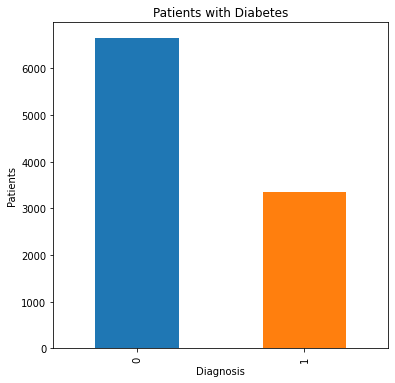

In [3]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace = ws, name = "diabetes-experiment")

# Start logging data from the experiment
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# load the data from a local file
data = pd.read_csv('data/diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])
        
# Save a sample of the data and upload it to the experiment output
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name = 'outputs/sample.csv', path_or_stream = './sample.csv')

# Complete the run
run.complete()

## View Experiment Results

After the experiment has been finished, you can use the **run** object to get information about the run and its outputs:

In [4]:
import json

# Get run details
details = run.get_details()
print(details)

# Get logged metrics
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

# Get output files
files = run.get_file_names()
print(json.dumps(files, indent=2))

{'runId': 'f3eecbf6-6968-4bb9-90f9-eb7e30ef6057', 'target': 'local', 'status': 'Completed', 'startTimeUtc': '2020-10-13T07:57:25.058981Z', 'endTimeUtc': '2020-10-13T07:57:47.019846Z', 'properties': {'azureml.git.repository_uri': 'https://github.com/microsoftdocs/mslearn-aml-labs', 'mlflow.source.git.repoURL': 'https://github.com/microsoftdocs/mslearn-aml-labs', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'c78a2a80560d94f753cf50afe18090e8b2da045d', 'mlflow.source.git.commit': 'c78a2a80560d94f753cf50afe18090e8b2da045d', 'azureml.git.dirty': 'True', 'ContentSnapshotId': '4d1dfd37-f025-4969-bd21-e047a812e8c8'}, 'inputDatasets': [], 'outputDatasets': [], 'logFiles': {}}
{
  "observations": 10000,
  "label distribution": "aml://artifactId/ExperimentRun/dcid.f3eecbf6-6968-4bb9-90f9-eb7e30ef6057/label distribution_1602575860.png",
  "pregnancy categories": [
    0,
    8,
    7,
    9,
    1,
    3,
    5,
    2,
    6,
    11,
    4,
    13,
   

In Jupyter Notebooks, you can use the **RunDetails** widget to get a better visualization of the run details, while the experiment is running or after it has finished.

In [5]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Note that the **RunDetails** widget includes a link to view the run in Azure Machine Learning studio. Click this to open a new browser tab with the run details (you can also just open [Azure Machine Learning studio](https://ml.azure.com) and find the run on the **Experiments** page). When viewing the run in Azure Machine Learning studio, note the following:

- The **Details** tab contains the general properties of the experiment run.
- The **Metrics** tab enables you to select logged metrics and view them as tables or charts.
- The **Images** tab enables you to select and view any images or plots that were logged in the experiment (in this case, the *Label Distribution* plot)
- The **Child Runs** tab lists any child runs (in this experiment there are none).
- The **Outputs + Logs** tab shows the output or log files generated by the experiment.
- The **Snapshot** tab contains all files in the folder where the experiment code was run (in this case, everything in the same folder as this notebook).
- The **Explanations** tab is used to show model explanations generated by the experiment (in this case, there are none).
- The **Fairness** tab is used to visualize predictive performance disparities that help you evaluate the fairness of machine learning models (in this case, there are none).

## Run an Experiment Script

In the previous example, you ran an experiment inline in this notebook. A more flexible solution is to create a separate script for the experiment, and store it in a folder along with any other files it needs, and then use Azure ML to run the experiment based on the script in the folder.

First, let's create a folder for the experiment files, and copy the data into it:

In [6]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

Now we'll create a Python script containing the code for our experiment, and save it in the experiment folder.

> **Note**: running the following cell just *creates* the script file - it doesn't run it!

In [ ]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

This code is a simplified version of the inline code used before. However, note the following:
- It uses the `Run.get_context()` method to retrieve the experiment run context when the script is run.
- It loads the diabetes data from the folder where the script is located.
- It creates a folder named **outputs** and writes the sample file to it - this folder is automatically uploaded to the experiment run

Now you're almost ready to run the experiment. There are just a few configuration issues you need to deal with:

1. Create a *Run Configuration* that defines the Python code execution environment for the script - in this case, it will automatically create a Conda environment with some default Python packages installed.
2. Create a *Script Configuration* that identifies the Python script file to be run in the experiment, and the environment in which to run it.

The following cell sets up these configuration objects, and then submits the experiment.

> **Note**: This will take a little longer to run the first time, as the conda environment must be created.

In [8]:
import os
import sys
from azureml.core import Experiment, RunConfiguration, ScriptRunConfig
from azureml.widgets import RunDetails

# create a new RunConfig object
experiment_run_config = RunConfiguration()

# Create a script config
src = ScriptRunConfig(source_directory=experiment_folder, 
                      script='diabetes_experiment.py',
                      run_config=experiment_run_config) 

# submit the experiment
experiment = Experiment(workspace = ws, name = 'diabetes-experiment')
run = experiment.submit(config=src)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-experiment_1598977045_7dc43652',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-09-01T16:19:12.084445Z',
 'endTimeUtc': '2020-09-01T16:19:21.876143Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '1c8134e2-6bb1-414f-a0e0-303c688649ca',
  'azureml.git.repository_uri': 'https://github.com/microsoftdocs/mslearn-aml-labs',
  'mlflow.source.git.repoURL': 'https://github.com/microsoftdocs/mslearn-aml-labs',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'c78a2a80560d94f753cf50afe18090e8b2da045d',
  'mlflow.source.git.commit': 'c78a2a80560d94f753cf50afe18090e8b2da045d',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'scriptType': None,
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local

As before, you can use the widget or the link to the experiment in [Azure Machine Learning studio](https://ml.azure.com) to view the outputs generated by the experiment, and you can also write code to retrieve the metrics and files it generated:

In [9]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/22946_azureml.log
outputs/sample.csv


## View Experiment Run History

Now that you've run the same experiment multiple times, you can view the history in [Azure Machine Learning studio](https://ml.azure.com) and explore each logged run. Or you can retrieve an experiment by name from the workspace and iterate through its runs using the SDK:

In [ ]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['diabetes-experiment']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Now you've seen how to use the Azure ML SDK to view the resources in your workspace and run experiments. 

### Learn More

- For more details about the SDK, see the [Azure ML SDK documentation](https://docs.microsoft.com/python/api/overview/azure/ml/intro?view=azure-ml-py).
- To find out more about running experiments, see [Start, monitor, and cancel training runs in Python](https://docs.microsoft.com/azure/machine-learning/how-to-manage-runs) in the Azure ML documentation.
- For details of how to log metrics in a run, see [Monitor Azure ML experiment runs and metrics](https://docs.microsoft.com/azure/machine-learning/how-to-track-experiments).

## Clean Up

On the **File** menu, click **Close and Halt** to close this notebook. Then close all Jupyter tabs in your browser and **stop** your compute instance to minimize costs.